In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OneHotEncoder # one-hot encoding
from sklearn.decomposition import PCA # PCA
from sklearn import tree, ensemble # decision tree, random forest
from sklearn.neighbors import KNeighborsClassifier # KNN

from sklearn import metrics
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.model_selection import KFold # K-fold validation
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.model_selection import cross_val_score

import graphviz
import random
import statistics

In [3]:
""" PCA """

def pca(dim, feature):
    pca_dim = PCA(dim)
    feature_pca = pca_dim.fit_transform(feature)
    
    return pd.DataFrame(feature_pca)

In [4]:
""" Data input """
data = pd.read_csv('student-mat.csv', sep=";")

""" Data preprocessing """

# one-hot representation
data = pd.get_dummies(data)

# add new col based on G3
data['pass'] = data['G3'].map(lambda x: 'pass' if x >= 10 else 'fail')
data['eval'] = 'A'
data.loc[data['G3']<16, 'eval'] = 'B'
data.loc[data['G3']<14, 'eval'] = 'C'
data.loc[data['G3']<12, 'eval'] = 'D'
data.loc[data['G3']<10, 'eval'] = 'E'

# shuffle
data = data.sample(frac=1)

# feature/label split
tmp = data.pop('G3')
data.insert(data.shape[1],'G3',tmp)

X = data.iloc[:,0:-3].values
y_eval = data.iloc[:,-2].values
y_pass = data.iloc[:,-3].values

feature_names = data.columns[0:-3]

In [5]:
def print_path(clf, X_test, sid):
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)

    sample_id = sid
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X_test[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )
        
    print('Prediction result: ' + str(clf.predict(X_test[[0]])))

In [6]:
def kfold(X, y, model, positive, pca_dim):
    
    K = 3
    score_sum = 0
    
    kf = KFold(n_splits=K)
    mats, accs, recalls, precisions = [], [], [], []
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        if pca_dim > 0:
            pca = PCA(pca_dim) 
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        clf = model.fit(X_train, y_train)

        # calculate result
        TP, FP, FN, TN = 0, 0, 0, 0
        pred = clf.predict(X_test)
        for i in range(len(X_test)):
            if pred[i] == positive and y_test[i] == positive:
                TP += 1
            elif pred[i] == positive and y_test[i] != positive:
                FP += 1
            elif pred[i] != positive and y_test[i] == positive:
                FN += 1
            elif pred[i] != positive and y_test[i] != positive:
                TN += 1
        mats.append(pd.DataFrame([[TP, FP], [FN, TN]]))
        accs.append((TP+TN)/len(X_test))
        recalls.append(TP/(TP+FN))
        precisions.append(TP/(TP+FP))
    
    confusion_mat = (mats[0]+mats[1]+mats[2])/K
    acc = sum(accs) / K
    recall = sum(recalls) / K
    precision = sum(precisions) / K
    
    # Return relevant data for chart plotting
    return confusion_mat, acc, recall, precision, clf, X_test

In [7]:
def class2num(c):
    if c == 'A':
        return 0
    elif c == 'B':
        return 1
    elif c == 'C':
        return 2
    elif c == 'D':
        return 3
    elif c == 'E':
        return 4

In [8]:
def kfold_multi(X, y, model, class_list, pca_dim):
    
    K = 3
    score_sum = 0
    
    kf = KFold(n_splits=K)
    mats, accs, recalls, precisions = [], [], [], []
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        if pca_dim > 0:
            pca = PCA(pca_dim) 
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        clf = model.fit(X_train, y_train)

        # calculate result
        mat = [[0]*5  for i in range(5)]
        pred = clf.predict(X_test)
        for i in range(len(X_test)):
            mat[class2num(pred[i])][class2num(y_test[i])] += 1
        mats.append(pd.DataFrame(mat))
    
    confusion_mat = (mats[0]+mats[1]+mats[2])/K
    
    for pos in class_list:
        positive = class2num(pos)
        TP, FP, FN, TN = 0, 0, 0, 0
        for i in range(5):
            for j in range(5):
                if i == positive and j == positive:
                    TP += confusion_mat[i][j]
                elif i == positive and j != positive:
                    FP += confusion_mat[i][j]
                elif i != positive and j == positive:
                    FN += confusion_mat[i][j]
                elif i != positive and j != positive:
                    TN += confusion_mat[i][j]
        accs.append((TP+TN)/len(X_test))
        recalls.append(TP/(TP+FN))
        precisions.append(TP/(TP+FP))
        
    # Return relevant data for chart plotting
    return confusion_mat, accs, recalls, precisions, clf, X_test

In [9]:
""" Model Construciton """

# decision tree
DT_clf = tree.DecisionTreeClassifier()

# random forest
RF_clf_10 = ensemble.RandomForestClassifier(n_estimators = 10)
RF_clf_20 = ensemble.RandomForestClassifier(n_estimators = 20)
RF_clf_50 = ensemble.RandomForestClassifier(n_estimators = 50)

# KNN
KNN_clf_5 = KNeighborsClassifier(n_neighbors=5)
KNN_clf_10 = KNeighborsClassifier(n_neighbors=10)
KNN_clf_20 = KNeighborsClassifier(n_neighbors=20)

In [10]:
def print_mat(mat):
    class_list = ['A','B','C','D','E']
    for i in range(5):
        print('|**' + class_list[i] + '**|',end='')
        for j in range(5):
            print('%.2f' % mat[i][j] + '|', end='')
        print()

def print_mat_bin(mat):
    class_list = ['pass','fail']
    for i in range(2):
        print('|**' + class_list[i] + '**|',end='')
        for j in range(2):
            print('%.2f' % mat[i][j] + '|', end='')
        print()
        
def print_perf(mat):
    class_list = ['A','B','C','D','E']
    for i in range(5):
        print('|**' + class_list[i] + '**|',end='')
        for j in range(12):
            print('%.2f' % (mat[i][j]*100) + '|', end='')
        print()  
        
def print_perf_bin(mat, rows):
    for i in range(len(rows)):
        print('|**' + rows[i] + '**|',end='')
        for j in range(len(mat[0])):
            print('%.2f' % (mat[i][j]*100) + '|', end='')
        print()  

In [15]:
""" Validation_DT """

# binary
confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, DT_clf, 'pass', 0)
print(confusion_mat, acc, recall, precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, DT_clf, 'pass', 2)
print(confusion_mat, acc, recall, precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, DT_clf, 'pass', 5)
print(confusion_mat, acc, recall, precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, DT_clf, 'pass', 10)
print(confusion_mat, acc, recall, precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, DT_clf, 'pass', 20)
print(confusion_mat, acc, recall, precision)


"""
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)
tree.plot_tree(clf,
               feature_names = feature_names, 
               class_names=,
               filled = True,
               node_ids=True)
print_path(clf,X_test,0)
"""

           0          1
0  80.000000  11.000000
1   8.333333  32.333333 0.8532269257460098 0.9050843486410497 0.8775841431768767
           0          1
0  80.333333  10.333333
1   8.000000  33.000000 0.8608219600586012 0.9096298031865042 0.8885122960272156
           0          1
0  79.000000   9.333333
1   9.333333  34.000000 0.8582196005860129 0.8943962824117463 0.8934734309359568
           0          1
0  80.666667   7.333333
1   7.666667  36.000000 0.8860552085742924 0.9159871915026554 0.9166769560027989
           0          1
0  80.333333  10.666667
1   8.000000  32.666667 0.8582003238491788 0.9114144017494533 0.8822616713156765


'\nfig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=800)\ntree.plot_tree(clf,\n               feature_names = feature_names, \n               class_names=,\n               filled = True,\n               node_ids=True)\nprint_path(clf,X_test,0)\n'

In [20]:
# 5-level
confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, DT_clf, ['A', 'B', 'C', 'D', 'E'], 0)
print(confusion_mat)
print([ '%.2f' % (elem*100) for elem in acc ])
print([ '%.2f' % (elem*100) for elem in recall ])
print([ '%.2f' % (elem*100) for elem in precision ])
confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, DT_clf, ['A', 'B', 'C', 'D', 'E'], 2)
print(confusion_mat)
print([ '%.2f' % (elem*100) for elem in acc ])
print([ '%.2f' % (elem*100) for elem in recall ])
print([ '%.2f' % (elem*100) for elem in precision ])

'''
# prediction & reasoning
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=1000)
tree.plot_tree(clf,
               feature_names = feature_names, 
               class_names=['A', 'B', 'C', 'D', 'E'],
               filled = True,
              node_ids=True)
print_path(clf,X_test,0)'''

          0         1          2          3          4
0  9.000000  5.333333   0.333333   0.000000   0.000000
1  4.333333  9.666667   4.000000   0.333333   0.000000
2  0.000000  5.000000  11.333333   6.000000   0.333333
3  0.000000  0.000000   4.666667  20.666667  11.666667
4  0.000000  0.000000   0.333333   7.333333  31.333333
['92.88', '86.01', '84.73', '77.61', '85.50']
['61.36', '52.73', '50.00', '55.86', '80.34']
['67.50', '48.33', '54.84', '60.19', '72.31']
          0          1         2          3          4
0  9.000000   2.666667  0.666667   0.000000   0.000000
1  4.333333  13.000000  5.333333   0.666667   0.000000
2  0.000000   4.000000  9.666667   7.666667   0.333333
3  0.000000   0.333333  4.333333  18.333333   9.666667
4  0.000000   0.000000  0.666667   7.666667  33.333333
['94.66', '87.28', '82.95', '77.35', '86.51']
['72.97', '55.71', '44.62', '56.12', '80.00']
['67.50', '65.00', '46.77', '53.40', '76.92']
|0.86|0.62|0.61|


"\n# prediction & reasoning\nfig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=1000)\ntree.plot_tree(clf,\n               feature_names = feature_names, \n               class_names=['A', 'B', 'C', 'D', 'E'],\n               filled = True,\n              node_ids=True)\nprint_path(clf,X_test,0)"

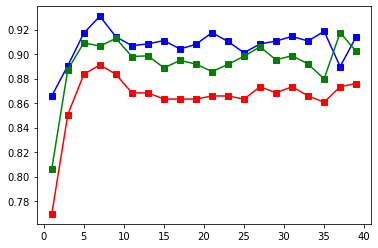

In [51]:
dim = range(1,40,2)
accs = []
recalls = []
precs = []

for d in dim:
    confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, DT_clf, 'pass', d)
    accs.append(acc)
    recalls.append(recall)
    precs.append(precision)

plt.plot(dim,accs,'s-',color = 'r', label="TSMC")
plt.plot(dim,recalls,'s-',color = 'b', label="TSMC")
plt.plot(dim,precs,'s-',color = 'g', label="TSMC")
plt.show()

|79.24|45.05|43.38|
|85.85|62.97|61.77|
|86.67|64.41|62.97|
|85.65|61.34|60.63|
|85.04|59.65|58.71|
|85.55|59.75|58.69|
|86.06|62.70|60.76|
|85.85|61.90|60.38|
|85.65|61.93|60.88|
|85.14|58.88|58.43|
|84.73|59.62|58.41|
|85.04|59.49|58.37|
|85.14|59.11|58.82|
|85.34|60.19|59.96|
|85.04|58.56|58.09|
|84.22|57.72|57.72|
|83.82|56.75|56.36|
|84.73|59.74|57.91|
|84.12|55.99|55.56|
|84.63|58.08|57.49|


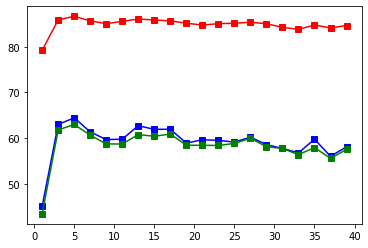

In [43]:
dim = range(1,40,2)
accs = []
recalls = []
precs = []

for d in dim:
    confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_pass, DT_clf, ['A', 'B', 'C', 'D', 'E'], d)
    accs.append(sum(acc)/5*100)
    recalls.append(sum(recall)/5*100)
    precs.append(sum(precision)/5*100)
    print('|%.2f|%.2f|%.2f|'% (sum(acc)/5*100, sum(recall)/5*100, sum(precision)/5*100))

plt.plot(dim,accs,'s-',color = 'r', label="TSMC")
plt.plot(dim,recalls,'s-',color = 'b', label="TSMC")
plt.plot(dim,precs,'s-',color = 'g', label="TSMC")
plt.show()

In [64]:
""" Validation_RF """

# binary
p = []
confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, RF_clf_10, 'pass', 0)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, RF_clf_20, 'pass', 0)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, RF_clf_50, 'pass', 0)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, RF_clf_50, 'pass', 7)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

print_perf_bin(p,['n=10','n=20','n=50','n=50(PCA)'])

|**pass**|79.67|8.67|
|**fail**|6.33|37.00|
|**pass**|81.67|6.67|
|**fail**|6.67|36.67|
|**pass**|81.67|6.67|
|**fail**|6.67|36.67|
|**pass**|82.33|6.00|
|**fail**|7.67|35.67|
|**n=10**|88.61|90.19|92.62|
|**n=20**|89.88|92.37|92.43|
|**n=50**|89.88|92.37|92.44|
|**n=50(PCA)**|89.62|93.19|91.49|


In [65]:
# 5-level
p = []
confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, RF_clf_10, ['A', 'B', 'C', 'D', 'E'], 0)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, RF_clf_20, ['A', 'B', 'C', 'D', 'E'], 0)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, RF_clf_50, ['A', 'B', 'C', 'D', 'E'], 0)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, RF_clf_50, ['A', 'B', 'C', 'D', 'E'], 7)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

p = list(map(list, zip(*p))) # transpose
print_perf(p)

|**A**|9.00|3.33|1.00|0.00|0.00|
|**B**|3.00|11.67|3.67|1.67|0.00|
|**C**|1.00|4.33|5.67|8.67|1.00|
|**D**|0.00|1.67|5.67|17.33|9.67|
|**E**|0.00|0.33|0.67|8.00|34.33|
|**A**|8.00|5.33|0.00|0.00|0.00|
|**B**|3.00|12.00|3.33|1.67|0.00|
|**C**|1.00|4.33|5.67|9.33|0.33|
|**D**|0.00|1.67|5.33|19.33|8.00|
|**E**|0.00|0.00|0.00|4.67|38.67|
|**A**|7.33|5.67|0.33|0.00|0.00|
|**B**|2.00|12.67|3.00|2.33|0.00|
|**C**|0.00|4.00|8.00|8.67|0.00|
|**D**|0.33|0.33|5.00|20.67|8.00|
|**E**|0.00|0.00|0.00|2.67|40.67|
|**A**|8.67|4.00|0.67|0.00|0.00|
|**B**|2.00|13.67|4.00|0.33|0.00|
|**C**|0.00|5.33|9.00|6.33|0.00|
|**D**|0.00|1.00|4.00|23.67|5.67|
|**E**|0.00|0.00|0.00|5.33|38.00|
|**A**|94.15|69.23|67.50|93.38|66.67|60.00|94.15|75.86|55.00|95.42|81.25|65.00|
|**B**|86.77|54.69|58.33|85.75|51.43|60.00|87.28|55.88|63.33|87.79|56.94|68.33|
|**C**|80.66|34.00|27.42|82.44|39.53|27.42|84.48|48.98|38.71|84.99|50.94|43.55|
|**D**|73.54|48.60|50.49|77.10|55.24|56.31|79.64|60.19|60.19|83.21|66.36|68.93|
|**E**|8

In [62]:
""" Validation_KNN """

# binary

p = []
confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, KNN_clf_5, 'pass', 0)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, KNN_clf_10, 'pass', 0)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, KNN_clf_20, 'pass', 0)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

confusion_mat, acc, recall, precision, clf, X_test = kfold(X, y_pass, KNN_clf_20, 'pass', 7)
print_mat_bin(confusion_mat)
p.append([acc, recall, precision])

print_perf_bin(p,['k=5','k=10','k=20','k=20(PCA)'])

|**pass**|82.00|6.33|
|**fail**|9.33|34.00|
|**pass**|81.00|7.33|
|**fail**|8.33|35.00|
|**pass**|83.00|5.33|
|**fail**|10.67|32.67|
|**pass**|81.67|6.67|
|**fail**|10.33|33.00|
|**k=5**|88.11|92.78|89.78|
|**k=10**|88.11|91.59|90.63|
|**k=20**|87.85|93.90|88.59|
|**k=20(PCA)**|87.09|92.38|88.77|


In [63]:
# 5-level
p = []
confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, KNN_clf_5, ['A', 'B', 'C', 'D', 'E'], 0)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, KNN_clf_10, ['A', 'B', 'C', 'D', 'E'], 0)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, KNN_clf_20, ['A', 'B', 'C', 'D', 'E'], 0)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

confusion_mat, acc, recall, precision, clf, X_test = kfold_multi(X, y_eval, KNN_clf_20, ['A', 'B', 'C', 'D', 'E'], 7)
print_mat(confusion_mat)
p.append(acc)
p.append(recall)
p.append(precision)

p = list(map(list, zip(*p))) # transpose
print_perf(p)

|**A**|7.67|5.00|0.67|0.00|0.00|
|**B**|3.67|13.33|2.33|0.67|0.00|
|**C**|0.00|6.67|6.33|7.67|0.00|
|**D**|0.00|1.00|9.33|17.67|6.33|
|**E**|0.00|0.00|0.33|9.00|34.00|
|**A**|7.67|5.00|0.67|0.00|0.00|
|**B**|2.33|14.00|2.67|1.00|0.00|
|**C**|0.00|5.33|6.00|9.33|0.00|
|**D**|0.00|0.33|5.00|23.33|5.67|
|**E**|0.00|0.00|0.00|12.00|31.33|
|**A**|7.00|5.67|0.67|0.00|0.00|
|**B**|0.67|15.67|2.00|1.67|0.00|
|**C**|0.00|5.33|5.33|10.00|0.00|
|**D**|0.00|0.67|3.67|24.00|6.00|
|**E**|0.00|0.00|0.00|10.67|32.67|
|**A**|6.67|5.33|1.33|0.00|0.00|
|**B**|1.00|15.33|2.00|1.67|0.00|
|**C**|0.00|5.00|5.33|10.00|0.33|
|**D**|0.00|0.33|3.00|25.00|6.00|
|**E**|0.00|0.00|0.00|11.00|32.33|
|**A**|93.38|67.65|57.50|94.40|76.67|57.50|95.17|91.30|52.50|94.66|86.96|50.00|
|**B**|85.75|51.28|66.67|87.79|56.76|70.00|88.30|57.32|78.33|88.80|58.97|76.67|
|**C**|79.90|33.33|30.65|82.95|41.86|29.03|83.97|45.71|25.81|83.97|45.71|25.81|
|**D**|74.55|50.48|51.46|75.06|51.09|67.96|75.57|51.80|69.90|76.08|52.45|72.82|
|**